# Análisis de la Brecha Digital en Uruguay: Perfiles de Conectividad y Factores Asociados (Censo 2023)

## Introducción

Este proyecto utiliza los microdatos del Censo de Población, Hogares y Viviendas de Uruguay 2023 para realizar un análisis de la brecha digital en el país. La brecha digital, entendida como las desigualdades en el acceso y uso de las Tecnologías de la Información y Comunicación (TIC), es un factor clave para el desarrollo social y económico. Comprender su magnitud, distribución geográfica y los factores asociados es fundamental para el diseño de políticas públicas efectivas.

El análisis se estructura en dos fases principales, combinando técnicas de aprendizaje no supervisado y supervisado para obtener una visión completa del fenómeno.

## Objetivos Generales

1.  **Identificar y caracterizar** diferentes perfiles o tipologías de hogares en Uruguay según su nivel y tipo de acceso a recursos digitales clave (internet y dispositivos).
2.  **Analizar la distribución geográfica** de estos perfiles de conectividad para visualizar las desigualdades territoriales.
3.  **Determinar los factores socioeconómicos, demográficos y de infraestructura** más relevantes que explican las diferencias en el acceso digital entre los hogares dentro de cada perfil identificado.

## Objetivos Específicos

**Fase 1: Identificación y Mapeo de Perfiles de Conectividad (Análisis No Supervisado)**

*   Aplicar algoritmos de clustering (Kmeans) sobre variables seleccionadas de hogares, viviendas y características del jefe/a de hogar para agrupar hogares con patrones similares de acceso a internet (`HOGCE11`), posesión de dispositivos (`HOGCE28`) y contexto clave (electricidad, educación del jefe, etc.).
*   Describir cada cluster resultante (perfil de hogar) en términos de sus características promedio de conectividad, socioeconómicas, demográficas y de vivienda.

**Fase 2: Análisis de Factores Relevantes por Perfil (Análisis Supervisado / Descriptivo)**

*   Para los perfiles identificados en la Fase 1 con menor conectividad:
    *   Construir modelos de clasificación para predecir la pertenencia a ese cluster vs otros, identificando los predictores más importantes.
    *   Realizar un análisis descriptivo comparando las características (educación, ocupación, tipo de hogar, etc.) de los hogares dentro de ese cluster con el promedio nacional o con otros clusters, para resaltar los factores diferenciales clave.
*   Interpretar los resultados para entender qué variables tienen mayor impacto en la probabilidad de que un hogar pertenezca a un perfil de baja conectividad, una vez considerado el contexto general definido por el cluster.

## Fuentes de Datos

*   Microdatos del Censo de Población, Hogares y Viviendas 2023 ([INE Uruguay](https://www.gub.uy/instituto-nacional-estadistica/politicas-y-gestion/microdatos-censo-2023-anonimizados)).
    *   [Dataset de Hogares](https://www5.ine.gub.uy/documents/CENSO%202023/Microdatos/hogares_ext_26_02.rar).
    *   [Dataset de Viviendas](https://www5.ine.gub.uy/documents/CENSO%202023/Microdatos/viviendas_ext_26_02.rar).
    *   [Dataset de Personas](https://www5.ine.gub.uy/documents/CENSO%202023/Microdatos/personas_ext_26_02.rar).
*   Documentación asociada a los microdatos ([Diccionarios de Variables](https://www5.ine.gub.uy/documents/CENSO%202023/Microdatos/Diccionario%20de%20variables%202023.xlsx)).

## Metodología Propuesta

1.  **Preprocesamiento:** Carga, limpieza, manejo de valores faltantes, filtrado por sub-universo relevante (hogares particulares ocupados), unión de los datasets.
2.  **Ingeniería de Características:** Creación de variables derivadas. Codificación de variables categóricas y escalado de numéricas según sea necesario para los algoritmos.
3.  **Fase 1 - Clustering:** Aplicación de Kmeans, selección del número óptimo de clusters, asignación de etiquetas de cluster.
4.  **Fase 2 - Análisis por Cluster:** Construcción y evaluación de modelos predictivos (o análisis descriptivo comparativo) para el cluster de interés. Interpretación de la importancia de variables.
5.  **Conclusiones:** Síntesis de los hallazgos sobre los perfiles de conectividad, su distribución y los factores asociados a la brecha digital.

## Resultados Esperados

*   Una tipología clara de hogares uruguayos basada en su perfil de conectividad digital.
*   Identificación y cuantificación de los factores (educativos, económicos, geográficos, de infraestructura) más determinantes de la exclusión digital, con especificidades según el perfil del hogar.
*   Insights relevantes para informar políticas públicas orientadas a reducir la brecha digital en Uruguay.

---
# FASE I: CLUSTERING

In [ ]:
# --- Variables a seleccionar para la FASE 1: CLUSTERING ---

# --- PARTE I: Dataset de HOGARES ---
variables_hogares_cluster = [
    # --- Claves ---
    'DIRECCION_ID',      # ID de la dirección (para unir con viviendas y personas)
    'VIVID',             # ID de Vivienda dentro de la Dirección
    'HOGID',             # ID del Hogar dentro de la vivienda

    # --- Variables Centrales de Conectividad (Features para Clustering) ---
    'HOGCE11',           # Acceso a Internet (Sí/No) [Categórica]
    'HOGCE28',           # Posesión de Computadora/Laptop/Tablet (Sí/No) [Categórica]

    # --- Variables de Contexto Socioeconómico/Estructural Clave (Features para Clustering) ---
    'HOGTE01',           # Tenencia de la vivienda [Categórica]
    'HOGPR01_CON_RRAA',  # Cantidad total de personas [Numérica]
    'HOGHD01',           # Cantidad de habitaciones usadas para dormir [Numérica]

    # --- Variables Geográficas (para describir/mapear después) ---
    'REGION_4',          # Región geográfica agregada
    'AREA',              # Zona (Urbana/Rural)
]

# --- PARTE II: Dataset de VIVIENDAS ---
variables_viviendas_cluster = [
    # --- Clave ---
    'DIRECCION_ID',      # ID de la dirección (para unir con hogares y personas)
    'VIVID',             # ID de Vivienda dentro de la Dirección

    # --- Variables de Contexto/Infraestructura Clave (Features para Clustering) ---
    'VIVDV07',           # Principal medio de alumbrado eléctrico [Categórica - Esencial!]
    'MATERIALIDAD',      # Índice agregado de calidad de materiales [Categórica/Ordinal]
]

# --- PARTE III: Dataset de PERSONAS ---
variables_personas_cluster = [
    # --- Claves ---
    'DIRECCION_ID',      # ID de la dirección (para unir con viviendas y hogares)
    'VIVID',             # ID de Vivienda dentro de la Dirección (para unir)
    'HOGID',             # ID del Hogar dentro de la vivienda (para unir)
    'PERID',             # ID de Persona (para usar, posiblemente, en resultado final)
    'PERPA01',           # Relación de parentesco (para identificar al jefe/a = 1)

    # --- Variables del Individuo (para extraer las del Jefe/a como Features para Clustering) ---
    'NIVELEDU',          # Máximo nivel educativo alcanzado [Categórica/Ordinal]
    'PERNA01_TRAMO',     # Edad agrupada en tramoS [Categórica/Ordinal]
]

# --- PASOS IMPORTANTES con estas variables ---
# 1. Cargar los datos usando estas listas.
# 2. Filtrar por SUB-UNIVERSO adecuado (hogares particulares ocupados...).
# 3. Unir Hogares y Viviendas (por VIVID).
# 4. Unir Personas con el resultado anterior (por HOGID).
# 5. Identificar al Jefe/a de Hogar (PERPA01 == 1) para cada HOGID.
# 6. Limpiar y transformar los datos.
# 7. Aplicar el algoritmo de clustering (Usaremos Kmeans).
# 8. Añadir la etiqueta del cluster resultante al dataframe.

In [ ]:
# -*- coding: utf-8 -*-
# ¡Celda especial para descargar los datos en Colab! Sugerido por la IA

!apt-get update -qq # -qq para menos output
!apt-get install -y unrar -qq # -y para aceptar automáticamente, -qq para menos output
print("✅ Utilidad 'unrar' instalada.")

import os

urls = {
    "hogares": "https://www5.ine.gub.uy/documents/CENSO%202023/Microdatos/hogares_ext_26_02.rar",
    "viviendas": "https://www5.ine.gub.uy/documents/CENSO%202023/Microdatos/viviendas_ext_26_02.rar",
    "personas": "https://www5.ine.gub.uy/documents/CENSO%202023/Microdatos/personas_ext_26_02.rar",
}

# Directorios para organizar
download_dir = "/content/downloads"
extract_dir = "/content/data"

os.makedirs(download_dir, exist_ok=True)
os.makedirs(extract_dir, exist_ok=True)

print(f"Directorios '{download_dir}' y '{extract_dir}' listos.")

print("\n--- Descargando archivos ---")
for key, url in urls.items():
    filename = os.path.basename(url)
    filename_safe = filename.replace("%20", "_")
    download_path = os.path.join(download_dir, filename_safe)

    print(f"Descargando {key} ({filename_safe})...")
    !wget -q -O "{download_path}" "{url}"
    print(f"Descarga de {key} completa en {download_path}")

print("\n--- Todas las descargas completadas ---")

print("\n--- Descomprimiendo archivos RAR ---")
rar_files_downloaded = [f for f in os.listdir(download_dir) if f.endswith(".rar")]

if not rar_files_downloaded:
    print("No se encontraron archivos .rar para descomprimir en", download_dir)
else:
    for rar_filename in rar_files_downloaded:
        rar_filepath = os.path.join(download_dir, rar_filename)
        print(f"Descomprimiendo {rar_filename} en {extract_dir}...")
        !unrar e -o+ "{rar_filepath}" "{extract_dir}/"
        print(f"Descompresión de {rar_filename} completada.")

print("\n--- Descompresión finalizada ---")

# Verificar los archivos extraídos
print("\n--- Archivos extraídos en", extract_dir, "---")
!ls -lh "{extract_dir}"

print("\n--- Limpiando archivos temporales ---")
!rm -rf "{download_dir}"
print("Directorios de descarga eliminado.")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ Utilidad 'unrar' instalada.
Directorios '/content/downloads' y '/content/data' listos.

--- Descargando archivos ---
Descargando hogares (hogares_ext_26_02.rar)...
Descarga de hogares completa en /content/downloads/hogares_ext_26_02.rar
Descargando viviendas (viviendas_ext_26_02.rar)...
Descarga de viviendas completa en /content/downloads/viviendas_ext_26_02.rar
Descargando personas (personas_ext_26_02.rar)...
Descarga de personas completa en /content/downloads/personas_ext_26_02.rar

--- Todas las descargas completadas ---

--- Descomprimiendo archivos RAR ---
Descomprimiendo viviendas_ext_26_02.rar en /content/data...

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/downloads/viviendas_ext_26_02.rar

Extracting  /content/data/viviendas_ext_26_02

In [ ]:
# --- Crear directorios ---
hogares_file = os.path.join(extract_dir, "hogares_ext_26_02.csv")
viviendas_file = os.path.join(extract_dir, "viviendas_ext_26_02.csv")
personas_file = os.path.join(extract_dir, "personas_ext_26_02.csv")

In [ ]:
# --- Importar librerías necesarias ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
# --- Cargar los datos ---
hogares = pd.read_csv(hogares_file, usecols=variables_hogares_cluster)
viviendas = pd.read_csv(viviendas_file, usecols=variables_viviendas_cluster)
personas = pd.read_csv(personas_file, usecols=variables_personas_cluster)

In [ ]:
# --- Analizar los nulos en el dataset de personas, lo solucionaremos mas adelante ---
print("NaNs en DIRECCION_ID:", personas['DIRECCION_ID'].isnull().sum())
print("NaNs en VIVID:", personas['VIVID'].isnull().sum())
print("NaNs en HOGID:", personas['HOGID'].isnull().sum())

NaNs en DIRECCION_ID: 351837
NaNs en VIVID: 351837
NaNs en HOGID: 351837


In [ ]:
# --- Solucionar el tema de los tipos de datos para que no generen problemas mas adelante ---
personas['DIRECCION_ID'] = personas['DIRECCION_ID'].astype('Int64')
personas['VIVID'] = personas['VIVID'].astype('Int64')
personas['HOGID'] = personas['HOGID'].astype('Int64')
personas['PERID'] = personas['PERID'].astype('Int64')
personas['PERPA01'] = personas['PERPA01'].astype('Int64')
personas['NIVELEDU'] = personas['NIVELEDU'].astype('Int64')

In [ ]:
# --- Creamos las variables KEY para poder unir los dataframes ---
viviendas['VIVIENDA_KEY'] = viviendas['DIRECCION_ID'].astype(str) + '_' + viviendas['VIVID'].astype(str)
viviendas = viviendas.drop(columns=['DIRECCION_ID', 'VIVID'])

hogares['VIVIENDA_KEY'] = hogares['DIRECCION_ID'].astype(str) + '_' + hogares['VIVID'].astype(str)
hogares['HOGAR_KEY'] = hogares['VIVIENDA_KEY'].astype(str) + '_' + hogares['HOGID'].astype(str)
hogares = hogares.drop(columns=['DIRECCION_ID', 'VIVID', 'HOGID'])

personas['VIVIENDA_KEY'] = personas['DIRECCION_ID'].astype(str) + "_" + personas['VIVID'].astype(str)
personas['HOGAR_KEY'] = personas['VIVIENDA_KEY'].astype(str) + "_" + personas['HOGID'].astype(str)
personas = personas.drop(columns=['VIVIENDA_KEY', 'DIRECCION_ID', 'VIVID', 'HOGID'])

In [ ]:
# --- Unir los dataframes de hogares y viviendas ---
df_base = pd.merge(hogares, viviendas, on='VIVIENDA_KEY', how='left')
df_base = df_base.drop(columns=['VIVIENDA_KEY'])

In [ ]:
# --- Filtramos las personas del hogar para obtener solo el referente ---
jefes = personas[personas['PERPA01'] == 1].copy()
jefes = jefes.drop(columns=['PERPA01'])

In [ ]:
# --- Unir el dataframe de personas con el dataframe base ---
df_extendido = pd.merge(df_base, jefes, on='HOGAR_KEY', how='left')

In [ ]:
# --- Analizamos los nulos en el dataframe extendido ---
print("NaNs en HOGAR_KEY:", df_extendido.isnull().sum())

NaNs en HOGAR_KEY: REGION_4               0
AREA                   0
HOGTE01                0
HOGHD01                0
HOGCE28                0
HOGCE11                0
HOGPR01_CON_RRAA       0
HOGAR_KEY              0
VIVDV07                0
MATERIALIDAD           0
PERID               4379
PERNA01_TRAMO       4379
NIVELEDU            4379
dtype: int64


In [ ]:
# --- Vamos a eliminar los hogares sin jefe ya que son hogares colectivos y no entran en el análisis ---
df_extendido = df_extendido.dropna()
df_extendido.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1250825 entries, 0 to 1255202
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   REGION_4          1250825 non-null  int64 
 1   AREA              1250825 non-null  int64 
 2   HOGTE01           1250825 non-null  int64 
 3   HOGHD01           1250825 non-null  int64 
 4   HOGCE28           1250825 non-null  int64 
 5   HOGCE11           1250825 non-null  int64 
 6   HOGPR01_CON_RRAA  1250825 non-null  int64 
 7   HOGAR_KEY         1250825 non-null  object
 8   VIVDV07           1250825 non-null  int64 
 9   MATERIALIDAD      1250825 non-null  object
 10  PERID             1250825 non-null  Int64 
 11  PERNA01_TRAMO     1250825 non-null  object
 12  NIVELEDU          1250825 non-null  Int64 
dtypes: Int64(2), int64(8), object(3)
memory usage: 136.0+ MB


In [ ]:
# --- Analizamos los valores únicos de cada columna ---
df_extendido.nunique()

,0
REGION_4,4
AREA,2
HOGTE01,6
HOGHD01,21
HOGCE28,4
HOGCE11,4
HOGPR01_CON_RRAA,25
HOGAR_KEY,1250825
VIVDV07,8
MATERIALIDAD,12


In [ ]:
df_extendido.REGION_4.value_counts()

,count
REGION_4,
2,589356
1,485013
3,123680
4,52776


In [ ]:
df_extendido.AREA.value_counts()

,count
AREA,
1,1198049
2,52776


In [ ]:
df_extendido.HOGTE01.value_counts()

,count
HOGTE01,
1,716354
3,318538
4,145764
2,64659
8888,5506
9898,4


In [ ]:
df_extendido.HOGHD01.value_counts()

,count
HOGHD01,
2,529434
1,447416
3,228544
4,34075
8888,5506
5,4591
6,821
7,224
8,108


In [ ]:
df_extendido.HOGCE28.value_counts()

,count
HOGCE28,
1,729579
2,515728
8888,5506
9898,12


In [ ]:
df_extendido.HOGCE11.value_counts()

,count
HOGCE11,
1,973807
2,271500
8888,5506
9898,12


In [ ]:
df_extendido.HOGPR01_CON_RRAA.value_counts()

,count
HOGPR01_CON_RRAA,
2,366646
1,364971
3,245081
4,171988
5,64744
6,22662
7,8475
8,3427
9,1477


In [ ]:
df_extendido.VIVDV07.value_counts()

,count
VIVDV07,
1,1236255
8888,5506
6,4092
5,2294
3,1755
4,380
9898,289
2,254


In [ ]:
df_extendido.MATERIALIDAD.value_counts()

,count
MATERIALIDAD,
Materiales pesados en paredes y techos y piso resistente,709138
"Materiales pesados en paredes, techo liviano y piso resistente",436569
Otras combinaciones de materiales,48756
Materiales livianos en paredes y techos y piso resistente,45669
8888,5506
Materiales livianos en paredes y techos y piso no resistente,1491
Materiales de desecho en paredes o techos,1419
"Paredes de barro o adobe, techo liviano y piso resistente",1405
"Materiales pesados en paredes, techo liviano y piso no resistente",691


In [ ]:
df_extendido.PERNA01_TRAMO.value_counts()

,count
PERNA01_TRAMO,
45-49,122912
40-44,117780
50-54,114752
35-39,113291
60-64,112931
55-59,109883
30-34,104296
65-69,102041
70-74,83304


In [ ]:
df_extendido.NIVELEDU.value_counts()

,count
NIVELEDU,
2,307545
4,299821
5,242974
9,184033
8,55269
7,49480
10,42500
12,37513
6,20780


In [ ]:
# --- Observacion 1 ---
# - Hay hogares con jefe marcado por error a personas menores de 15 años, se eliminarán.
tramos_a_eliminar = ['0-04', '05-09', '10-14']

# Contamos cuántos vamos a eliminar
n_a_eliminar = df_extendido[df_extendido['PERNA01_TRAMO'].isin(tramos_a_eliminar)].shape[0]
print(f"Se eliminarán {n_a_eliminar} hogares con jefe de hogar de edad 0-14 años.")

# Filtramos el dataframe para mantener solo los que NO están en esos tramos
df_extendido = df_extendido[~df_extendido['PERNA01_TRAMO'].isin(tramos_a_eliminar)].copy()

# Verificamos el resultado
df_extendido.PERNA01_TRAMO.value_counts()

Se eliminarán 1141 hogares con jefe de hogar de edad 0-14 años.


,count
PERNA01_TRAMO,
45-49,122912
40-44,117780
50-54,114752
35-39,113291
60-64,112931
55-59,109883
30-34,104296
65-69,102041
70-74,83304


In [ ]:
copia_seguridad = df_extendido.copy()

In [ ]:
# df_extendido = copia_seguridad.copy()

In [ ]:
# --- Observacion 2 ---
# - Códigos genéricos (9999, 9898, 8888, 7777, 99), se procesarán como NaN (-1 y 'desconocido').

# Lista de códigos presentes a reemplazar
codigos_invalidos = [9898, 8888, '9898', '8888'] # Dato ignorado (9898) y dato no relevado (8888)

# Itera sobre las columnas que se usarán como features
col_num = ['NIVELEDU', 'VIVDV07', 'HOGCE28', 'HOGCE11', 'HOGTE01', 'HOGPR01_CON_RRAA', 'HOGHD01']
col_cat = ['MATERIALIDAD']

for col in col_num:
    if col in df_extendido.columns:
        df_extendido[col] = df_extendido[col].replace(codigos_invalidos, -1)
for col in col_cat:
    if col in df_extendido.columns:
        df_extendido[col] = df_extendido[col].replace(codigos_invalidos, 'Desconocido')

In [ ]:
# --- Observacion 3 ---
# Antes de seguir, analizamos el sesgo de eliminar datos faltantes en HOGCE11 (objetivo)
pd.crosstab(df_extendido['HOGCE11'] == -1, df_extendido['REGION_4'], normalize='columns')

REGION_4,1,2,3,4
HOGCE11,,,,
False,0.994935,0.996292,0.9966,0.991333
True,0.005065,0.003708,0.0034,0.008667


In [ ]:
pd.crosstab(df_extendido['HOGCE11'] == -1, df_extendido['AREA'], normalize='columns')

AREA,1,2
HOGCE11,,
False,0.995774,0.991333
True,0.004226,0.008667


In [ ]:
# --- Procedemos a eliminar los hogares con datos faltantes en HOGCE11 (el sesgo es mínimo) ---
df_extendido = df_extendido[df_extendido['HOGCE11'] != -1]

In [ ]:
# --- Analizamos los NaNs después de la imputación ---
print("NaNs después de imputación:")
print(df_extendido.isnull().sum())

NaNs después de imputación:
REGION_4            0
AREA                0
HOGTE01             0
HOGHD01             0
HOGCE28             0
HOGCE11             0
HOGPR01_CON_RRAA    0
HOGAR_KEY           0
VIVDV07             0
MATERIALIDAD        0
PERID               0
PERNA01_TRAMO       0
NIVELEDU            0
dtype: int64


In [ ]:
# --- Verificar los datos que nos quedaron ---
df_extendido.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1244169 entries, 0 to 1255202
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   REGION_4          1244169 non-null  int64 
 1   AREA              1244169 non-null  int64 
 2   HOGTE01           1244169 non-null  int64 
 3   HOGHD01           1244169 non-null  int64 
 4   HOGCE28           1244169 non-null  int64 
 5   HOGCE11           1244169 non-null  int64 
 6   HOGPR01_CON_RRAA  1244169 non-null  int64 
 7   HOGAR_KEY         1244169 non-null  object
 8   VIVDV07           1244169 non-null  int64 
 9   MATERIALIDAD      1244169 non-null  object
 10  PERID             1244169 non-null  Int64 
 11  PERNA01_TRAMO     1244169 non-null  object
 12  NIVELEDU          1244169 non-null  Int64 
dtypes: Int64(2), int64(8), object(3)
memory usage: 135.3+ MB


In [ ]:
# --- Verificar datos duplicados ---
duplicados = df_extendido[df_extendido.duplicated()]
print(f"Cantidad de filas duplicadas: {duplicados.shape[0]}")

Cantidad de filas duplicadas: 0


In [ ]:
df_extendido.REGION_4.value_counts()

,count
REGION_4,
2,586580
1,482201
3,123114
4,52274


In [ ]:
df_extendido.AREA.value_counts()

,count
AREA,
1,1191895
2,52274


In [ ]:
df_extendido.HOGTE01.value_counts()

,count
HOGTE01,
1,715812
3,318162
4,145617
2,64578


In [ ]:
df_extendido.HOGHD01.value_counts()

,count
HOGHD01,
2,528772
1,447198
3,228314
4,34045
5,4587
6,820
7,224
8,108
9,46


In [ ]:
df_extendido.HOGCE28.value_counts()

,count
HOGCE28,
1,728856
2,515313


In [ ]:
df_extendido.HOGCE11.value_counts()

,count
HOGCE11,
1,972948
2,271221


In [ ]:
df_extendido.HOGPR01_CON_RRAA.value_counts()

,count
HOGPR01_CON_RRAA,
2,364981
1,362464
3,243860
4,171236
5,64461
6,22533
7,8419
8,3405
9,1464


In [ ]:
df_extendido.VIVDV07.value_counts()

,count
VIVDV07,
1,1235114
6,4089
5,2292
3,1755
4,380
-1,285
2,254


In [ ]:
df_extendido.MATERIALIDAD.value_counts()

,count
MATERIALIDAD,
Materiales pesados en paredes y techos y piso resistente,708600
"Materiales pesados en paredes, techo liviano y piso resistente",436155
Otras combinaciones de materiales,48643
Materiales livianos en paredes y techos y piso resistente,45598
Materiales livianos en paredes y techos y piso no resistente,1490
Materiales de desecho en paredes o techos,1413
"Paredes de barro o adobe, techo liviano y piso resistente",1402
"Materiales pesados en paredes, techo liviano y piso no resistente",690
Materiales pesados en paredes y techos y piso no resistente,103


In [ ]:
df_extendido.PERNA01_TRAMO.value_counts()

,count
PERNA01_TRAMO,
45-49,122372
40-44,117312
50-54,114284
35-39,112792
60-64,112422
55-59,109432
30-34,103788
65-69,101599
70-74,82929


In [ ]:
df_extendido.NIVELEDU.value_counts()

,count
NIVELEDU,
2,307186
4,299546
5,242972
9,184032
8,55269
7,49480
10,42500
12,37500
6,20780


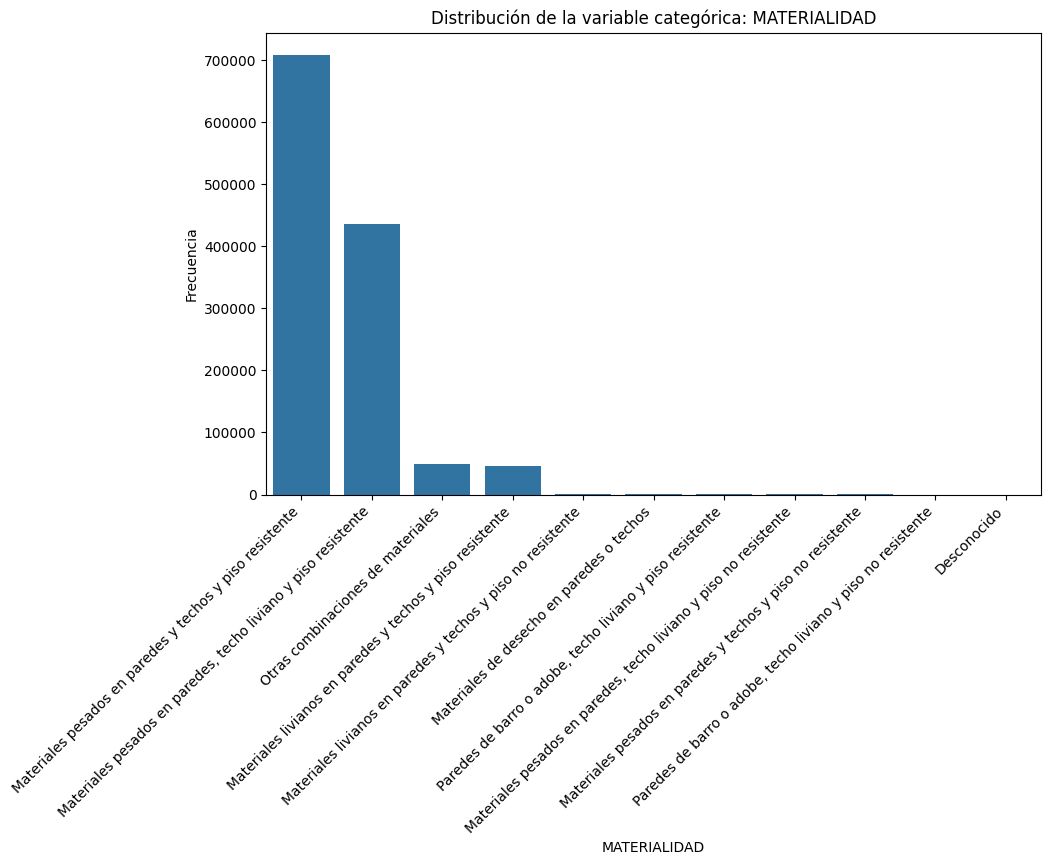

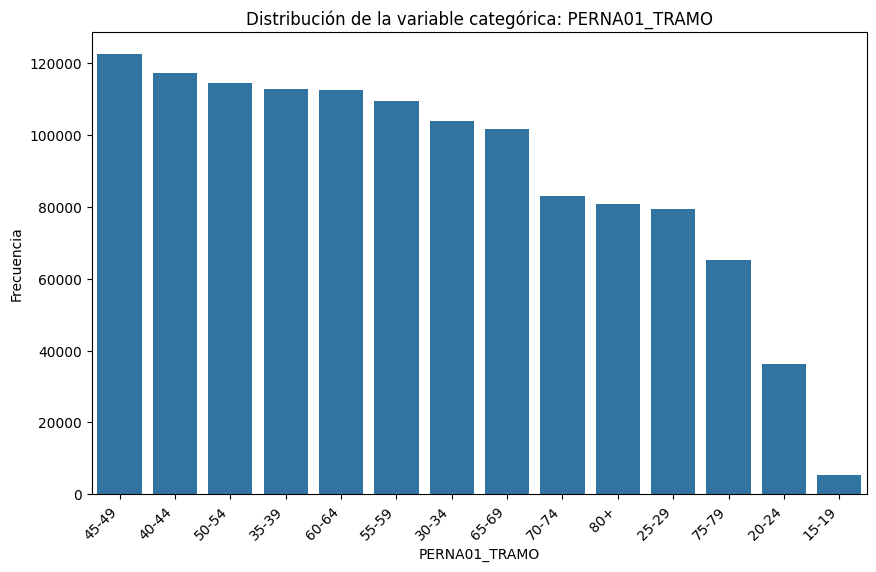

In [ ]:
# Graficar la distribución de cada variable categórica
for col in ['MATERIALIDAD', 'PERNA01_TRAMO']:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_extendido, x=col, order=df_extendido[col].value_counts().index)
    plt.title(f'Distribución de la variable categórica: {col}')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

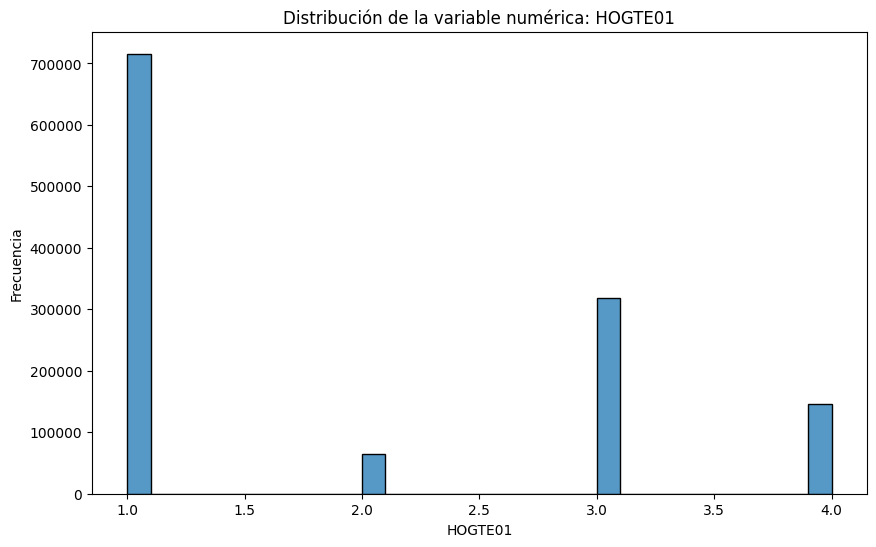

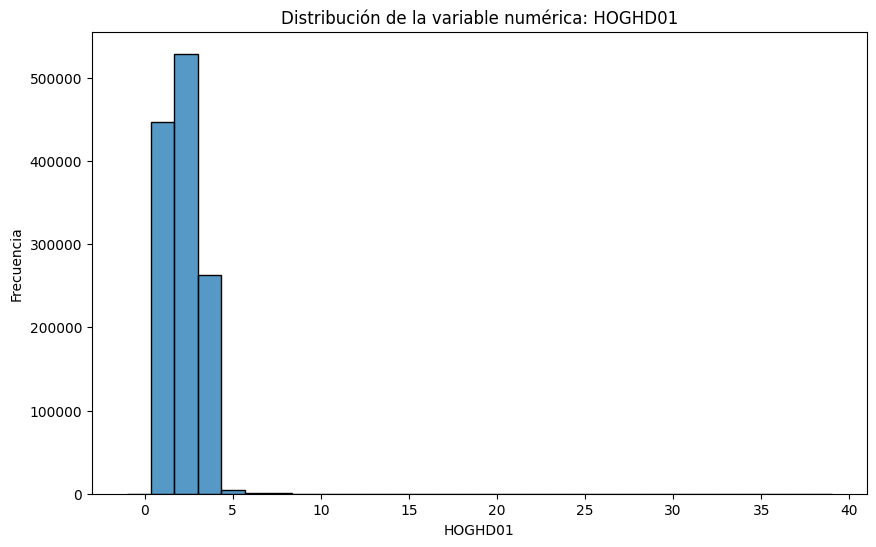

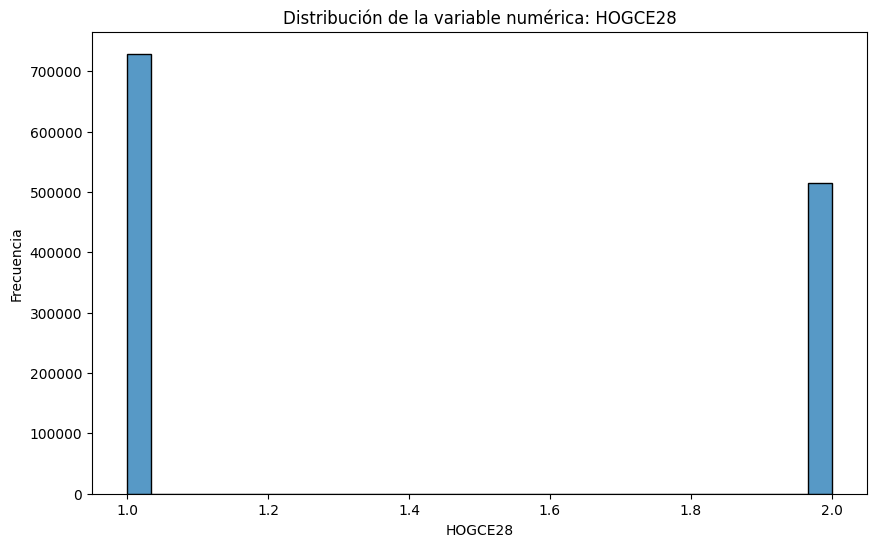

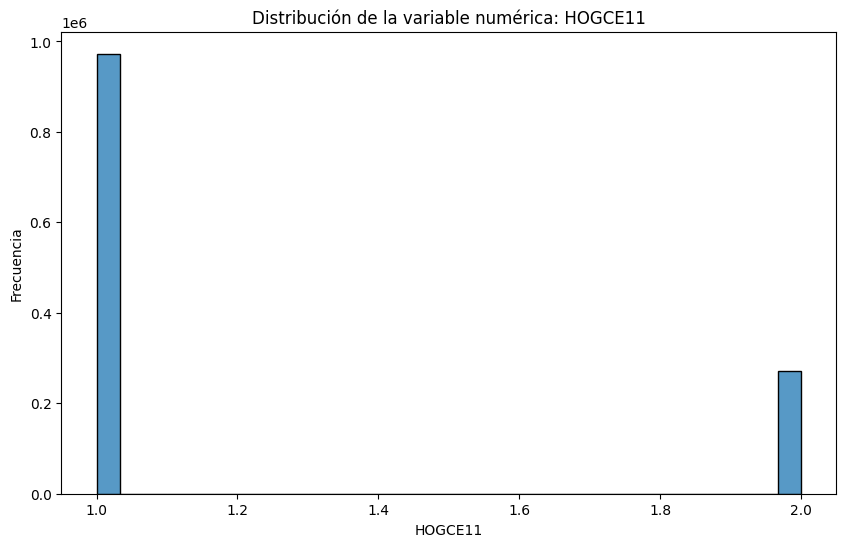

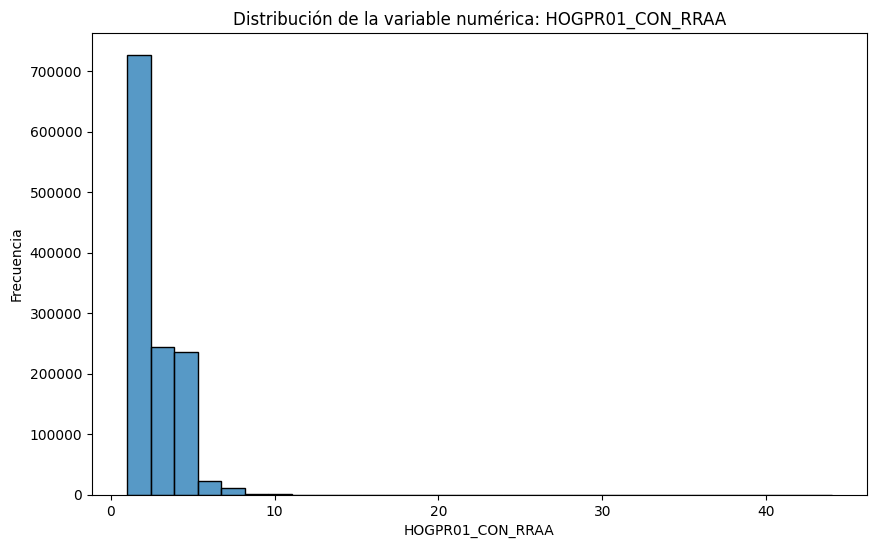

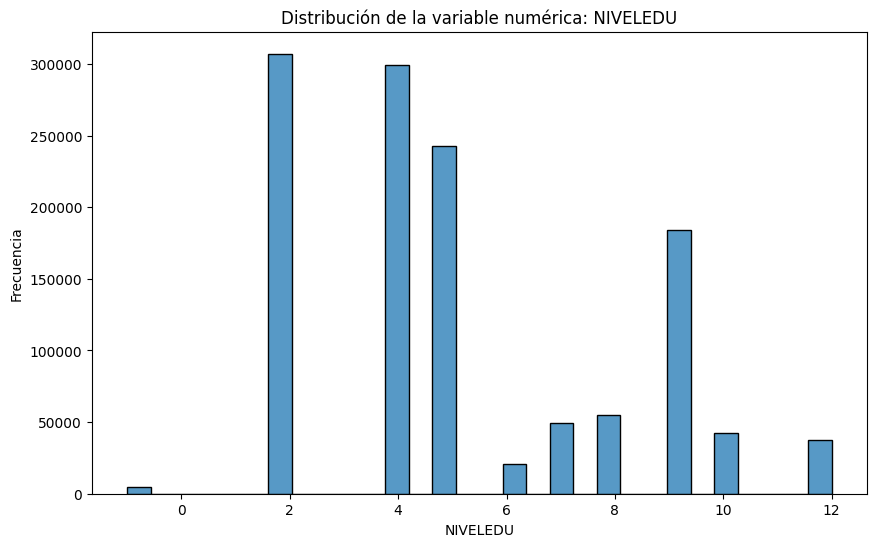

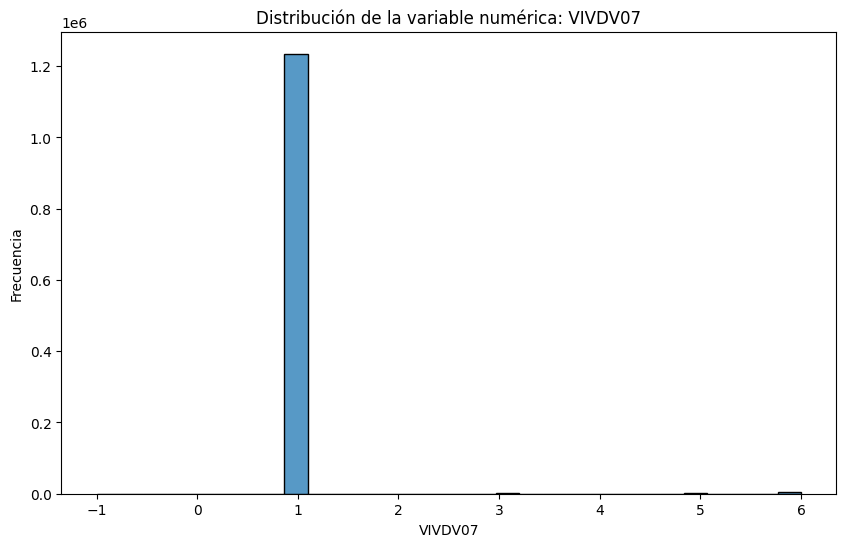

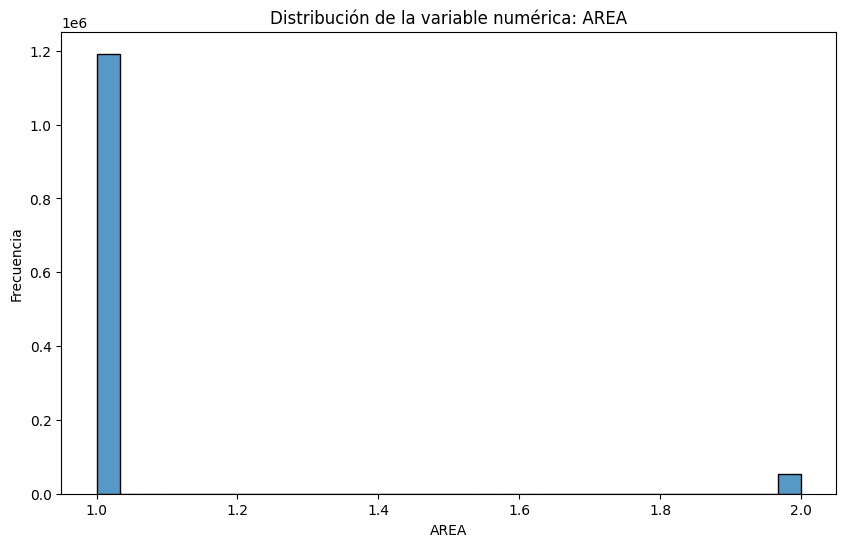

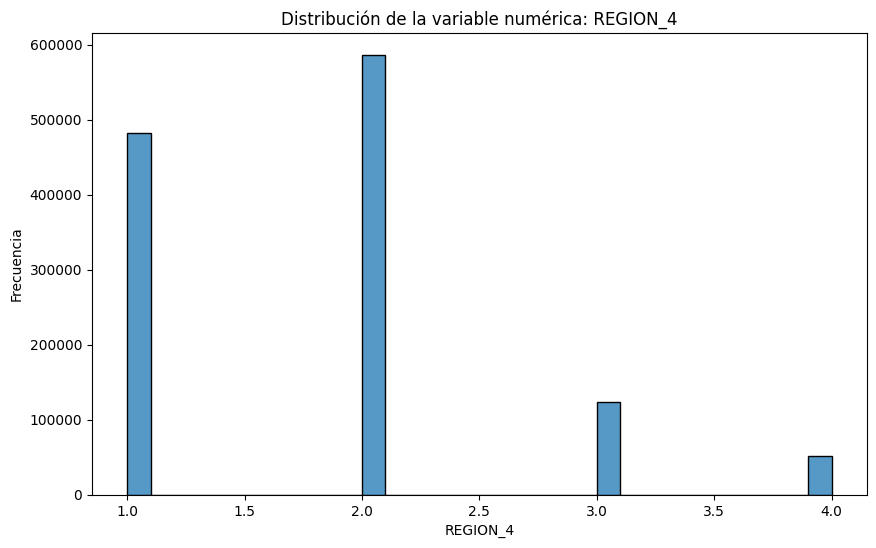

In [ ]:
# Graficar la distribución de cada variable numérica (muchas son categóricas)
numerical_columns = ['HOGTE01', 'HOGHD01', 'HOGCE28', 'HOGCE11', 'HOGPR01_CON_RRAA', 'NIVELEDU', 'VIVDV07', 'AREA', 'REGION_4']

for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_extendido, x=col, bins=30)
    plt.title(f'Distribución de la variable numérica: {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

In [ ]:
copia_seguridad = df_extendido.copy()

In [ ]:
# df_extendido = copia_seguridad.copy()

In [ ]:
# --- Observacion 4 ---
# - Debo reesctructurar las categorías de NIVELEDU, llevando el 12 a 0 y subiendo un lugar las tres mas bajas.
# - NOTA: para el valor desconocido (-1) existe la opcion de mantenerlo o imputarlo (ej: knnimputer, mediana o media). Mi decisión es mantenerlo.

recode_mapping = {
    12: 0,
    0: 1,
    1: 2,
    2: 3,
}

df_extendido['NIVELEDU'] = df_extendido['NIVELEDU'].replace(recode_mapping).astype('Int64')

In [ ]:
# --- Observacion 5 ---
# - Vamos a reagrupar la variable MATERIALIDAD en 4 grupos, para que no haya tantos niveles.
# - Se agruparán los siguientes niveles:

materialidad_map = {
    # Buena
    "Materiales pesados en paredes y techos y piso resistente": 'Buena',

    # Media
    "Materiales pesados en paredes, techo liviano y piso resistente": 'Media',
    "Materiales pesados en paredes y techos y piso no resistente": 'Media',
    "Materiales livianos en paredes y techos y piso resistente": 'Media',
    "Otras combinaciones de materiales": 'Media',
    "Desconocido": 'Media',

    # Precaria
    "Materiales pesados en paredes, techo liviano y piso no resistente": 'Precaria',
    "Materiales livianos en paredes y techos y piso no resistente": 'Precaria',
    "Paredes de barro o adobe, techo liviano y piso resistente": 'Precaria',
    "Paredes de barro o adobe, techo liviano y piso no resistente": 'Precaria',
    "Materiales de desecho en paredes o techos": 'Precaria',
}

# Creamos la nueva columna agrupada usando .map()
df_extendido['MATERIALIDAD_Agrupada'] = df_extendido['MATERIALIDAD'].map(materialidad_map)

# Verificar los nuevos valores
print("\nValores en MATERIALIDAD_Agrupada:")
print(df_extendido['MATERIALIDAD_Agrupada'].value_counts(dropna=False))

# Convertir a tipo category para eficiencia
df_extendido['MATERIALIDAD_Agrupada'] = df_extendido['MATERIALIDAD_Agrupada'].astype('category')


Valores en MATERIALIDAD_Agrupada:
MATERIALIDAD_Agrupada
Buena       708600
Media       530535
Precaria      5034
Name: count, dtype: int64


In [ ]:
# --- Observacion 6 ---
# - Vamos a agrupar la variable VIVDV07 en dos grupos
# Si VIVDV07 es 1 (categoría correspondiente a red pública), asigna 'Red_Publica'
# En cualquier otro caso, asigna 'Otro_o_Sin_Luz'
df_extendido['VIVDV07_Agrupada'] = np.where(
    df_extendido['VIVDV07'] == 1,    # Condición: ¿Utiliza UTE?
    'Red_Publica',                   # Valor si la condición es Verdadera
    'Otro_o_Sin_Luz'                 # Valor si la condición es Falsa
)

# Verificar los nuevos valores
print("\nValores en VIVDV07_Agrupada:")
print(df_extendido['VIVDV07_Agrupada'].value_counts(dropna=False))

# Convertir a tipo category
df_extendido['VIVDV07_Agrupada'] = df_extendido['VIVDV07_Agrupada'].astype('category')


Valores en VIVDV07_Agrupada:
VIVDV07_Agrupada
Red_Publica       1235114
Otro_o_Sin_Luz       9055
Name: count, dtype: int64


In [ ]:
# --- Observacion 7 ---
# - Vamos a agrupar la variable HOGHD01 en grupos

# Definimos la función para agrupar
def agrupar_habitaciones(n):
    if n == 1:
        return '1_hab'
    elif n == 2:
        return '2_hab'
    elif n == 3:
        return '3_hab'
    elif n >= 4:
        return '4_o_mas_hab'
    else: # Para valores -1
        return 'Desconocido'

# Creamos la nueva columna agrupada usando .apply()
df_extendido['HOGHD01_Agrupada'] = df_extendido['HOGHD01'].apply(agrupar_habitaciones)

# Verificar los nuevos valores
print("\nValores en HOGHD01_Agrupada:")
print(df_extendido['HOGHD01_Agrupada'].value_counts(dropna=False))


Valores en HOGHD01_Agrupada:
HOGHD01_Agrupada
2_hab          528772
1_hab          447198
3_hab          228314
4_o_mas_hab     39876
Desconocido         9
Name: count, dtype: int64


In [ ]:
# Escalamos las variables numericas y ordinales (NIVELEDU, HOGPR01_CON_RRAA) usando RobustScaler (ideal para datos con valores atípicos)
scaler = RobustScaler()
num_col = ['HOGPR01_CON_RRAA', 'NIVELEDU']
df_extendido[num_col] = scaler.fit_transform(df_extendido[num_col]).astype('int64')

In [ ]:
# Creamos las variables dummy para las variables categóricas (MATERIALIDAD_agrupada, HOGTE01, VIVDV07_Agrupada, AREA, REGION_4, HOGCE11, HOGCE28, PERNA01_TRAMO)
cat_col = ['MATERIALIDAD_Agrupada', 'HOGHD01_Agrupada', 'HOGTE01', 'VIVDV07_Agrupada', 'AREA', 'REGION_4', 'HOGCE11', 'HOGCE28', 'PERNA01_TRAMO']
IDs = df_extendido[['HOGAR_KEY', 'PERID']].copy()
df_extendido = df_extendido.drop(columns=['HOGAR_KEY', 'PERID', 'MATERIALIDAD', 'HOGHD01', 'VIVDV07'])
df_extendido = pd.get_dummies(df_extendido, columns=cat_col, drop_first=True)

In [ ]:
df_extendido.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1244169 entries, 0 to 1255202
Data columns (total 31 columns):
 #   Column                          Non-Null Count    Dtype
---  ------                          --------------    -----
 0   HOGPR01_CON_RRAA                1244169 non-null  int64
 1   NIVELEDU                        1244169 non-null  int64
 2   MATERIALIDAD_Agrupada_Media     1244169 non-null  bool 
 3   MATERIALIDAD_Agrupada_Precaria  1244169 non-null  bool 
 4   HOGHD01_Agrupada_2_hab          1244169 non-null  bool 
 5   HOGHD01_Agrupada_3_hab          1244169 non-null  bool 
 6   HOGHD01_Agrupada_4_o_mas_hab    1244169 non-null  bool 
 7   HOGHD01_Agrupada_Desconocido    1244169 non-null  bool 
 8   HOGTE01_2                       1244169 non-null  bool 
 9   HOGTE01_3                       1244169 non-null  bool 
 10  HOGTE01_4                       1244169 non-null  bool 
 11  VIVDV07_Agrupada_Red_Publica    1244169 non-null  bool 
 12  AREA_2                          1

--- Calculando Métricas para K en [2, 3, 4, 5, 6, 7] ---
--- Usando sample_size=50000 para Silhouette ---
Probando k = 2...
  -> fit_predict completado en 23.79 seg.
  -> Silhouette Score calculado en 43.20 seg.
  Resultado k = 2: Silhouette Score: 0.1027, Inertia: 3669326.90
--------------------
Probando k = 3...
  -> fit_predict completado en 35.67 seg.
  -> Silhouette Score calculado en 40.67 seg.
  Resultado k = 3: Silhouette Score: 0.1039, Inertia: 3406334.76
--------------------
Probando k = 4...
  -> fit_predict completado en 38.77 seg.
  -> Silhouette Score calculado en 39.45 seg.
  Resultado k = 4: Silhouette Score: 0.0899, Inertia: 3253986.58
--------------------
Probando k = 5...
  -> fit_predict completado en 35.73 seg.
  -> Silhouette Score calculado en 40.21 seg.
  Resultado k = 5: Silhouette Score: 0.0879, Inertia: 3112054.00
--------------------
Probando k = 6...
  -> fit_predict completado en 42.70 seg.
  -> Silhouette Score calculado en 39.33 seg.
  Resultado k = 6: S

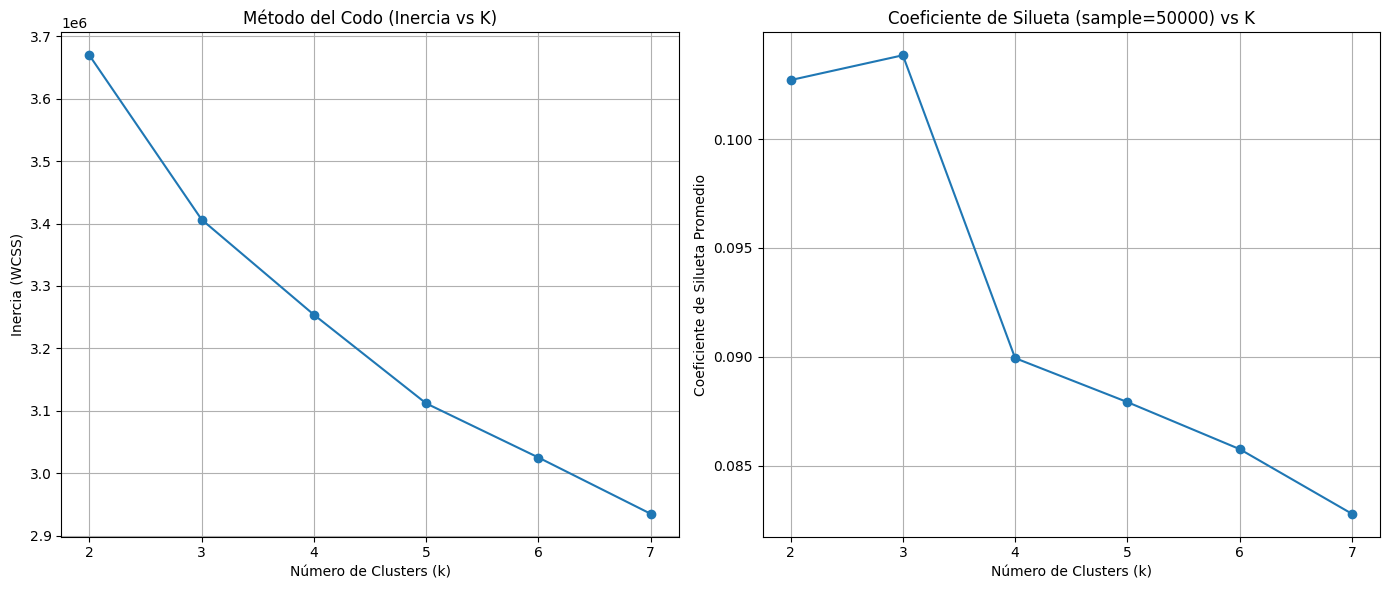

In [ ]:
# Analizamos el numero de clusters a usar en Kmeans con el método del codo
# Nota: Opción que me dio la AI ya que mi código era demasiado intensivo.

import time # Para medir el tiempo

# 1. Definir el rango y tamaño de muestra
k_range = range(2, 8) # Puedes ajustar el rango (ej: hasta 10 si quieres explorar más)
silhouette_sample_size = 50000 # Tamaño de la muestra para Silhouette (ajusta según RAM/tiempo)
# Asegúrate que sample_size no sea mayor que el número de filas en tus datos
if silhouette_sample_size > df_extendido.shape[0]:
    silhouette_sample_size = df_extendido.shape[0]
    print(f"Aviso: sample_size reducido a {silhouette_sample_size} (tamaño total del dataset)")

silhouette_scores = []
inertia_scores = []

print(f"--- Calculando Métricas para K en {list(k_range)} ---")
print(f"--- Usando sample_size={silhouette_sample_size} para Silhouette ---")

for k in k_range:
    start_time = time.time()
    print(f"Probando k = {k}...")

    kmeans = KMeans(n_clusters=k,
                    init='k-means++',
                    n_init=10, # n_init=10 es importante para estabilidad
                    max_iter=300,
                    random_state=42)

    # Ajustar y predecir sobre los datos PREPROCESADOS
    cluster_labels = kmeans.fit_predict(df_extendido)
    fit_predict_time = time.time()
    print(f"  -> fit_predict completado en {fit_predict_time - start_time:.2f} seg.")

    # Calcular Silhouette Score
    # Asegúrate de pasar los datos PREPROCESADOS
    score = silhouette_score(df_extendido,
                             cluster_labels,
                             sample_size=silhouette_sample_size,
                             random_state=42) # Añadir random_state para reproducibilidad del sampleo
    silhouette_scores.append(score)
    silhouette_time = time.time()
    print(f"  -> Silhouette Score calculado en {silhouette_time - fit_predict_time:.2f} seg.")

    # Calcular Inercia
    # Nota: La inercia de MiniBatchKMeans no es directamente comparable a KMeans
    inertia = kmeans.inertia_
    inertia_scores.append(inertia)

    print(f'  Resultado k = {k}: Silhouette Score: {score:.4f}, Inertia: {inertia:.2f}')
    print("-" * 20)

# 2. Graficar los resultados (sin cambios en esta parte)
plt.figure(figsize=(14, 6))
# ... (resto del código de ploteo igual que antes) ...
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia_scores, marker='o', linestyle='-')
plt.title('Método del Codo (Inercia vs K)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia (WCSS)')
plt.xticks(list(k_range))
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-')
plt.title(f'Coeficiente de Silueta (sample={silhouette_sample_size}) vs K') # Indica sample size
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Coeficiente de Silueta Promedio')
plt.xticks(list(k_range))
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Creamos los clusters con el número óptimo (3 en este caso)

n_clusters = 3

# Inicializar el modelo K-Means
kmeans = KMeans(n_clusters=n_clusters,
                init='k-means++', # Algoritmo de inicialización estándar
                n_init=10,        # Número de veces que se ejecuta con diferentes centroides iniciales
                max_iter=300,     # Máximo de iteraciones por ejecución
                random_state=42)

# Entrenamos el modelo y predecimos los clusters
cluster = kmeans.fit_predict(df_extendido)

# Añadimos las etiquetas de cluster al dataframe
df_extendido['Cluster'] = cluster

In [ ]:
# Verificamos el resultado
print(f"\nSe asignaron etiquetas para {n_clusters} clusters.")
print("Distribución de hogares por cluster:")
print(df_extendido['Cluster'].value_counts())
print("\nDistribución de hogares por cluster (en porcentaje):")
print(df_extendido['Cluster'].value_counts(normalize=True) * 100)


Se asignaron etiquetas para 3 clusters.
Distribución de hogares por cluster:
Cluster
1    532337
0    460652
2    251180
Name: count, dtype: int64

Distribución de hogares por cluster (en porcentaje):
Cluster
1    42.786551
0    37.024874
2    20.188576
Name: proportion, dtype: float64


In [ ]:
# Agregamos los clusters a nuestro dataset extendido original (sin el procesado)
df_original = copia_seguridad.copy()
df_original['Cluster'] = cluster

In [ ]:
# Ahora analizamos las características de cada cluster contra la conectividad

# Analizmos HOGCE11 por Cluster
print("\nDistribución de Acceso a Internet (HOGCE11) por Cluster:")
# normalize='index' muestra el porcentaje DENTRO de cada cluster
print(pd.crosstab(df_original['Cluster'], df_original['HOGCE11'], normalize='index').round(3) * 100)

# Analizamos HOGCE28 por Cluster
print("\nDistribución de Posesión de Dispositivo (HOGCE28) por Cluster:")
print(pd.crosstab(df_original['Cluster'], df_original['HOGCE28'], normalize='index').round(3) * 100)


Distribución de Acceso a Internet (HOGCE11) por Cluster:
HOGCE11     1     2
Cluster            
0        51.0  49.0
1        96.7   3.3
2        88.9  11.1

Distribución de Posesión de Dispositivo (HOGCE28) por Cluster:
HOGCE28     1     2
Cluster            
0         4.0  96.0
1        97.7   2.3
2        75.8  24.2


In [ ]:
print("\nCaracterísticas Numéricas Promedio por Cluster:")
print(df_original.groupby('Cluster')[['HOGPR01_CON_RRAA', 'NIVELEDU']].median().round(2))


Características Numéricas Promedio por Cluster:
         HOGPR01_CON_RRAA  NIVELEDU
Cluster                            
0                     2.0       4.0
1                     2.0       6.0
2                     4.0       4.0


**Hallazgos Clave Fase 1:** Mediante clustering (K-Means), se segmentaron los hogares uruguayos en tres grupos con patrones de conectividad y perfiles sociodemográficos diferenciados. Notablemente, se identificó un **Cluster 0 (~37% de los hogares)** que concentra la brecha digital, con solo 51.0% reportando acceso a internet y una mínima penetración de dispositivos (4.0%). Se caracteriza no tanto por una ausencia total de conexión (51% reporta acceso a internet), sino por una dependencia casi exclusiva de la conectividad móvil, evidenciada por la bajísima posesión de dispositivos como computadoras o tablets (4%). Esto sugiere una brecha digital centrada en el acceso limitado a herramientas para usos más avanzados de internet. Este grupo, asociado a hogares pequeños y bajo nivel educativo del jefe. Contrasta fuertemente con el **Cluster 1**, de alta conectividad general (97%) y mayor concentración en Montevideo y jefes de mayor nivel educativo, y con el **Cluster 2**, de alta conexión a internet pero menor acceso a dispositivos (89%/76%), caracterizado por hogares más grandes. La clara identificación del Cluster 0 como el segmento más vulnerable, con un componente territorial evidente, justifica proceder a la Fase 2 para analizar en profundidad sus características determinantes.

In [ ]:
# # Guardamos el dataset para su uso posterior
df_original.to_csv('/content/data/df_final.csv', index=False)
df_extendido.to_csv('/content/data/df_extendido.csv', index=False)

---
# Fase 2: Identificación de Factores Asociados a Baja Conectividad (Cluster 0)

## Objetivo

Identificar las características socioeconómicas, demográficas y de vivienda más importantes que distinguen a los hogares del **Cluster 0 (Baja Conectividad)** del resto de la población (Clusters 1 y 2).

## Metodología

1.  **Target:** Crear variable binaria `BajaConectividad` (1 si Cluster=0, 0 si Cluster=1 ó 2).
2.  **Features:** Utilizar las variables descriptivas empleadas en la Fase 1 para el clustering (excluyendo `HOGCE11`/`HOGCE28`).
3.  **Modelado:** Entrenar modelos de clasificación **LightGBM** y **XGBoost** para predecir `BajaConectividad`.
4.  **Análisis:** Extraer y comparar la **importancia de features (`feature_importances_`)** de ambos modelos para determinar los factores más relevantes asociados a la baja conectividad.

> **Nota**: *La idea inicial era usar más variables en esta segunda fase, lamentablemente no me fue posible por tema de tiempo y la dificultad adicional asociada con la limpieza de nuevos datos.*

In [ ]:
# --- Importar librerías necesarias ---
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import lightgbm as lgb
import xgboost as xgb
import pandas as pd
import time

In [ ]:
# df_extendido = pd.read_csv('/content/data/df_extendido.csv')

In [ ]:
# --- Crear la Variable Target 'BajaConectividad' ---

# Target = 1 si Cluster es 0, sino Target = 0
df_extendido['BajaConectividad'] = (df_extendido['Cluster'] == 0).astype(int)

# Verificar la distribución del target
print("\nDistribución de la variable objetivo 'BajaConectividad':")
print(df_extendido['BajaConectividad'].value_counts(normalize=True).round(3) * 100) # En porcentaje


Distribución de la variable objetivo 'BajaConectividad':
BajaConectividad
0    63.0
1    37.0
Name: proportion, dtype: float64


Dimensiones de X: (1244169, 29)
Dimensiones de y: (1244169,)
Distribución del target y:
BajaConectividad
0    0.629751
1    0.370249
Name: proportion, dtype: float64

Tamaño set Entrenamiento: X=(995335, 29), y=(995335,)
Tamaño set Prueba (Unseen): X=(248834, 29), y=(248834,)
Distribución del target y_train:
BajaConectividad
0    0.629751
1    0.370249
Name: proportion, dtype: float64
Distribución del target y_test:
BajaConectividad
0    0.629753
1    0.370247
Name: proportion, dtype: float64

--- Entrenando LightGBM ---
[LightGBM] [Info] Number of positive: 368522, number of negative: 626813
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.131047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 64
[LightGBM] [Info] Number of data points in the train set: 995335, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=

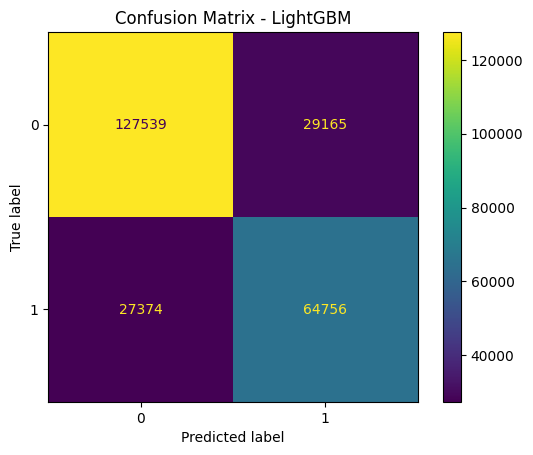


--- Entrenando XGBoost ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:39:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  -> Entrenamiento XGBoost completado en 20.44 seg.

--- Evaluación XGBoost (en datos de prueba) ---
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82    156704
           1       0.69      0.71      0.70     92130

    accuracy                           0.77    248834
   macro avg       0.76      0.76      0.76    248834
weighted avg       0.78      0.77      0.77    248834

ROC AUC Score: 0.8617

Confusion Matrix (XGBoost):


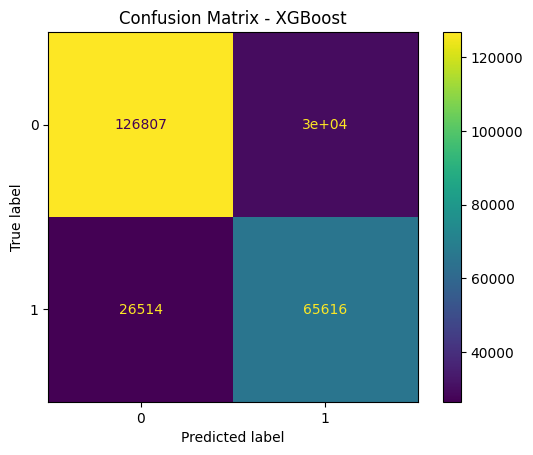


--- Comparación de Métricas Clave ---
LGBM ROC AUC: 0.8615
XGBoost ROC AUC: 0.8617


In [ ]:
# --- 1. Separar Features (X) y Target (y) ---

# Definir columnas a excluir de las features
ids_a_excluir = ['Cluster', 'HOGCE11_2', 'HOGCE28_2']

# Nombre de la columna Target
target = 'BajaConectividad'

# Seleccionar columnas features
columnas_features = df_extendido.columns.difference(ids_a_excluir + [target]).tolist()

X = df_extendido[columnas_features]
y = df_extendido[target]

# --- 2. Separar Datos en Entrenamiento y Prueba ---
# test_size=0.2 significa 20% para prueba, 80% para entrenamiento
# stratify=y asegura que la proporción de clases (0 y 1) sea similar en ambos sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nTamaño set Entrenamiento: X={X_train.shape}, y={y_train.shape}")
print(f"Tamaño set Prueba: X={X_test.shape}, y={y_test.shape}")
print(f"Distribución del target y_train:\n{y_train.value_counts(normalize=True)}")
print(f"Distribución del target y_test:\n{y_test.value_counts(normalize=True)}")

# --- 3. Entrenar y Evaluar LightGBM ---

print("\n--- Entrenando LightGBM ---")
start_time_lgbm = time.time()

# Creamos el modelo
lgbm_model = lgb.LGBMClassifier(random_state=42)

# Entrenamos
lgbm_model.fit(X_train, y_train)
fit_time_lgbm = time.time()
print(f"  -> Entrenamiento LGBM completado en {fit_time_lgbm - start_time_lgbm:.2f} seg.")

# Predecimos en el set de prueba
y_pred_lgbm = lgbm_model.predict(X_test)
y_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]

# Evaluamos LGBM
print("\n--- Evaluación LightGBM (en datos de prueba) ---")
print("Classification Report:")
print(classification_report(y_test, y_pred_lgbm))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_lgbm):.4f}")

print("\nConfusion Matrix (LGBM):")
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
disp_lgbm = ConfusionMatrixDisplay(confusion_matrix=cm_lgbm)
disp_lgbm.plot()
plt.title('Confusion Matrix - LightGBM')
plt.show()

# --- 4. Entrenar y Evaluar XGBoost ---

print("\n--- Entrenando XGBoost ---")
start_time_xgb = time.time()

# Creamos el modelo (es mejor usar logloss para modelos de clasificación)
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Entrenamos sobre X_train
xgb_model.fit(X_train, y_train)
fit_time_xgb = time.time()
print(f"  -> Entrenamiento XGBoost completado en {fit_time_xgb - start_time_xgb:.2f} seg.")

# Predecimos en el set de prueba
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluamos XGBoost
print("\n--- Evaluación XGBoost (en datos de prueba) ---")
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_xgb):.4f}")

print("\nConfusion Matrix (XGBoost):")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp_xgb.plot()
plt.title('Confusion Matrix - XGBoost')
plt.show()

# --- 5. Comparación y Selección del Mejor Modelo ---
print("\n--- Comparación de Métricas Clave ---")
print(f"LGBM ROC AUC: {roc_auc_score(y_test, y_proba_lgbm):.4f}")
print(f"XGBoost ROC AUC: {roc_auc_score(y_test, y_proba_xgb):.4f}")


Modelo seleccionado: XGBoost

Importancia de Features (del mejor modelo):
                           Feature  Importance
5                 HOGPR01_CON_RRAA    0.322669
11                        NIVELEDU    0.224102
2           HOGHD01_Agrupada_3_hab    0.072959
9      MATERIALIDAD_Agrupada_Media    0.059223
24               PERNA01_TRAMO_80+    0.048514
1           HOGHD01_Agrupada_2_hab    0.033608
15             PERNA01_TRAMO_35-39    0.029984
14             PERNA01_TRAMO_30-34    0.026791
16             PERNA01_TRAMO_40-44    0.023914
3     HOGHD01_Agrupada_4_o_mas_hab    0.019585
17             PERNA01_TRAMO_45-49    0.017266
23             PERNA01_TRAMO_75-79    0.014314
8                        HOGTE01_4    0.011918
10  MATERIALIDAD_Agrupada_Precaria    0.011505
13             PERNA01_TRAMO_25-29    0.011450


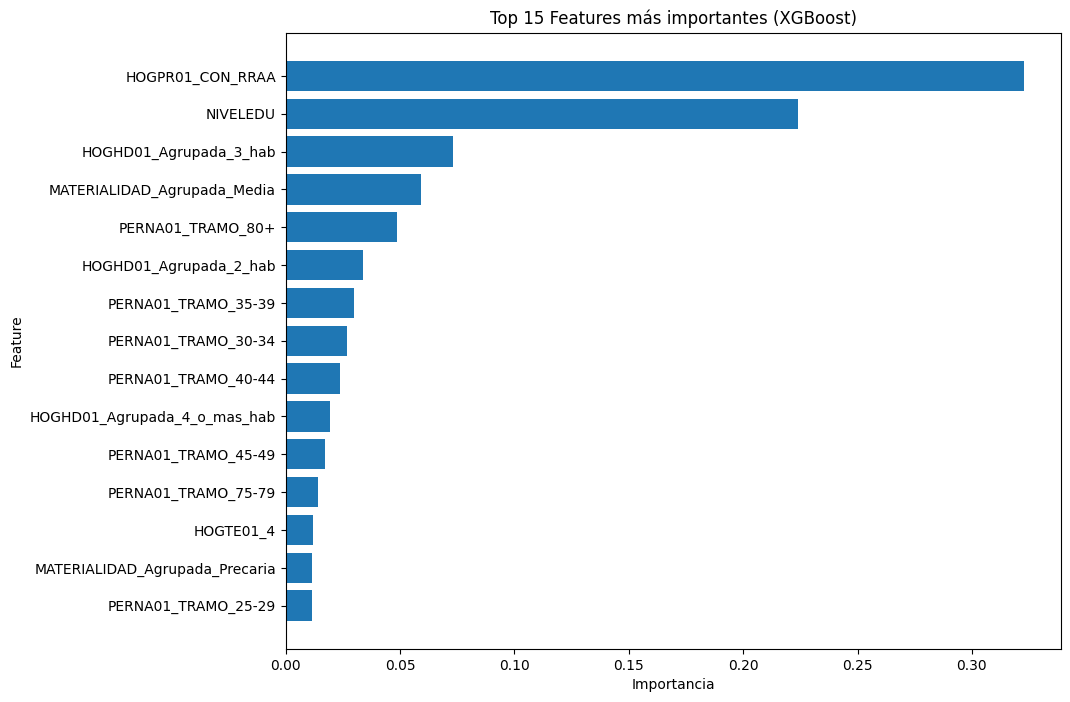

In [ ]:
# Guardar el MEJOR modelo entrenado
if roc_auc_score(y_test, y_proba_lgbm) > roc_auc_score(y_test, y_proba_xgb):
    mejor_modelo = lgbm_model
    mejor_modelo_nombre = "LightGBM"
    print("\nModelo seleccionado: LightGBM")
else:
    mejor_modelo = xgb_model
    mejor_modelo_nombre = "XGBoost"
    print("\nModelo seleccionado: XGBoost")

# Guardamos la importancia de las features del mejor modelo
importances = mejor_modelo.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("\nImportancia de Features (del mejor modelo):")
print(feature_importance_df.head(15)) # Mostrar las 15 más importantes
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'][:15], feature_importance_df['Importance'][:15])
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title(f"Top 15 Features más importantes ({mejor_modelo_nombre})")
plt.gca().invert_yaxis()
plt.show()

---

# Conclusiones del Análisis de Brecha Digital (Censo 2023)

Este proyecto analizó la brecha digital en Uruguay utilizando microdatos del Censo 2023, combinando técnicas de clustering y clasificación para identificar perfiles de conectividad y los factores asociados a la baja adopción tecnológica.

## Hallazgos Fase 1: Perfiles de Conectividad (Clustering K-Means)

Se identificaron tres clusters principales de hogares: **Cluster 1 ("Alta Conectividad")**, con acceso casi universal, mayor nivel educativo del jefe y concentración en Montevideo; **Cluster 2 ("Conectividad Media-Alta / Hogares Grandes")**, con alta conexión a internet pero menor penetración de dispositivos y caracterizado por hogares más grandes; y **Cluster 0 ("Baja Conectividad / Exclusión Digital")**, núcleo de la brecha digital (~51% internet, ~4% dispositivos), asociado a hogares pequeños, bajo nivel educativo del jefe y con una **mayor presencia relativa en el Interior del país y zonas rurales**.

Se identificaron **tres clusters principales** de hogares con características distintivas:

1.  **Cluster 1 ("Alta Conectividad"):** Acceso casi universal a internet y dispositivos, asociado a hogares con mayor nivel educativo del jefe y concentración en Montevideo.
2.  **Cluster 2 ("Conectividad Media-Alta / Hogares Grandes"):** Alta conexión a internet pero menor penetración de dispositivos, caracterizado por ser hogares significativamente más grandes.
3.  **Cluster 0 ("Baja Conectividad / Exclusión Digital"):** Marcado por un bajo acceso a internet (51%) y muy baja posesión de dispositivos (4%) caracterizado, no tanto por una ausencia total de conexión (51% reporta acceso a internet), sino por una dependencia casi exclusiva de la conectividad móvil, evidenciada por la bajísima posesión de dispositivos como computadoras o tablets (4%). Esto sugiere una brecha digital centrada en el acceso limitado a herramientas para usos más avanzados de internet, asociado a hogares pequeños, bajo nivel educativo del jefe y con una **mayor presencia relativa en el Interior del país y zonas rurales**. Este cluster representa el núcleo de la brecha digital.

## Hallazgos Fase 2: Factores Determinantes de la Baja Conectividad (XGBoost/LightGBM)

Para entender qué diferencia al Cluster 0 del resto, se entrenaron modelos de clasificación (XGBoost/LightGBM). El análisis de importancia de features reveló los siguientes factores como los más determinantes para predecir la pertenencia al grupo de baja conectividad:

1. **`HOGPR01_CON_RRAA` (Número de Personas):** La variable más importante. Aunque los Clusters 0 y 1 tienen un tamaño promedio similar (2.0 personas), esta variable es crucial porque **distingue fuertemente a los hogares más grandes (promedio 4.0) del Cluster 2**, que por lo tanto no pertenecen al grupo de baja conectividad (Cluster 0). Un tamaño reducido del hogar es una condición necesaria, aunque no suficiente, para pertenecer al Cluster 0 o 1.
2.  **`NIVELEDU` (Nivel Educativo del Jefe):** Factor clave. Un menor nivel educativo diferencia claramente al Cluster 0 (promedio 4.0) del Cluster 1 (promedio 6.0), ambos de tamaño similar, asociando baja educación con baja conectividad.
3.  **`HOGHD01_Agrupada` (Habitaciones):** Menor número de habitaciones asociado al Cluster 0, reforzando la asociación de baja conectividad con hogares más pequeños y/o con posible hacinamiento relativo.
4.  **`MATERIALIDAD_Agrupada` (Calidad Vivienda):** La categoría "Media" y (en menor medida) "Precaria" son relevantes, sugiriendo que condiciones de vivienda no óptimas se asocian con menor conectividad, probablemente como proxy de nivel socioeconómico.
5.  **`PERNA01_TRAMO` (Edad del Jefe):** Varios tramos de edad aparecen en el top 15, destacando **"80+"** y rangos de **edad media (30-49)**. Esto sugiere que tanto hogares con jefes muy mayores como algunos en edad activa pero con otras carencias (bajo nivel educativo) son propensos a la baja conectividad.

## Conclusión General

El análisis confirma la existencia de una brecha digital significativa en Uruguay (Cluster 0), asociada a **bajo nivel educativo del jefe**, **tamaño reducido del hogar** (aunque compartido con el cluster de alta conectividad), **condiciones de vivienda no óptimas**, **edad avanzada o media del jefe**, y una **mayor incidencia fuera de la capital y en zonas rurales**. La **educación** emerge como el principal diferenciador socioeconómico directo de la baja conectividad, mientras que el tamaño del hogar ayuda a segmentar otros perfiles. Las condiciones socioeconómicas (reflejadas por educación, materialidad) y territoriales son determinantes estructurales clave.